# Welcome to our notebook on Model Selection in Bandit Algorithms

Authors : Lila Mekki, Théo Moret, Augustin Cablant

First, make sure to import the necessary libraries. 

In [ ]:
!pip install -r requirements.txt   # install required packages

In [1]:
from utils.plot_regret import plot_regret
from utils.Experiment import experiment
from Agents.RB_agent import RegretBalancingAgent
from environments.BernoulliBanditEnv import BernoulliBanditEnv
import matplotlib.pyplot as plt
import numpy as np
from Agents.EpsilonGreedy import EpsilonGreedy
from utils.ActionGenerator import ActionsGenerator
from utils.Play import play
from Agents.UCB import UCB
from Agents.LinUCB import LinUCB
from Agents.RB_representation import RegretBalancing_Representation
from environments.BanditEnv import BanditEnv
from environments.LinearBandit import LinearBandit
import random
import pandas as pd
import sys
#from utils import score
sys.path.pop(0)
from RealData.EpsGreedy import epsilon_greedy_policy, run_epsilon_policy
from RealData.RegretBalancing import RunRegretBalancingEpsilonGreedy
from RealData.LoadData import create_dataframe
from RealData.UCB import run_UCB_policy
from kaggle_environments import make, evaluate
import gymnasium as gym
from tqdm import tqdm
import argparse
from numpy.linalg import norm, pinv

np.random.seed(2025)

## First, let us introduce $ \epsilon $-greedy algorithm

### Fixed $\epsilon$

/Users/augustincablant/Documents/GitHub/Advanced-ML/src/utils/plot_regret.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


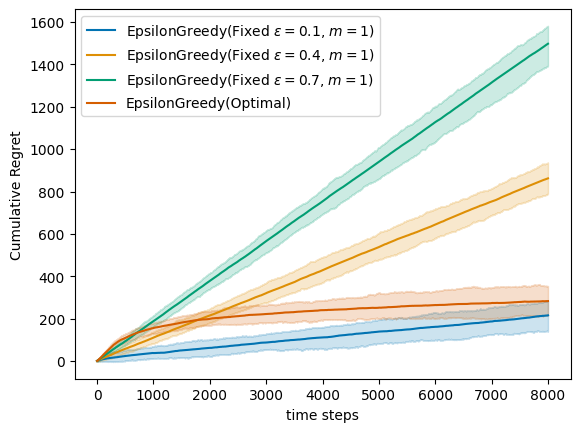

In [7]:
#Arms definition and Bernoulli environment
n_arms = 3
means = [0.2, 0.5, 0.75]
env = BernoulliBanditEnv(means = means)

#Initialization of eps-algo, with fixed epsilon
eps0 = EpsilonGreedy(K=len(means), eps = 0.1, FixedEpsilon = True, m = 1) 
eps04 = EpsilonGreedy(K=len(means), eps = 0.4, FixedEpsilon = True, m = 1) 
eps07 = EpsilonGreedy(K=len(means), eps = 0.7, FixedEpsilon = True, m = 1) 
epsOpti = EpsilonGreedy(K=len(means), Delta = 0.25, m = 1)

epsAlgo = [eps0, eps04, eps07, epsOpti]

#Run experiments
Nmc = 100  # Number of Monte Carlo simulations
T = 20 ** 3  # Number of rounds
all_data = experiment(env, epsAlgo, Nmc, T, bern = True)

#Plot results
plot_regret(regrets = all_data, logscale = False, lb = None, q = 10)

### Time varying $\varepsilon_t$

/Users/augustincablant/Documents/GitHub/Advanced-ML/src/utils/plot_regret.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


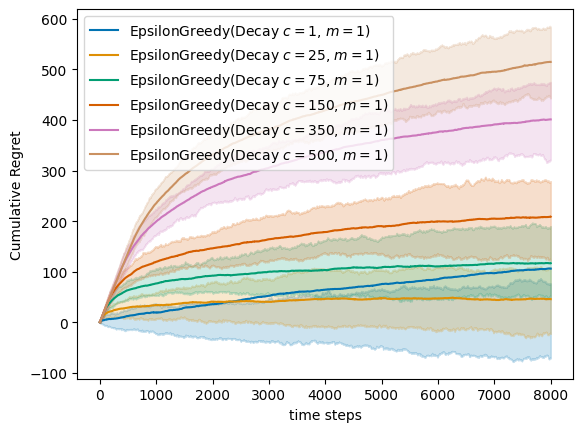

In [9]:
#Arms definition and Bernoulli environment
n_arms = 2
means = [0.2, 0.75]
env = BernoulliBanditEnv(means = means)

epsOpti = EpsilonGreedy(K=len(means), Delta = 0.55, m = 1)

epsAlgo = [EpsilonGreedy(K=len(means), FixedEpsilon = False, decay_param=1, m = 1),
           EpsilonGreedy(K=len(means), FixedEpsilon = False, decay_param=25, m = 1),
           EpsilonGreedy(K=len(means), FixedEpsilon = False, decay_param=75, m = 1),
           EpsilonGreedy(K=len(means), FixedEpsilon = False, decay_param=150, m = 1),
           EpsilonGreedy(K=len(means), FixedEpsilon = False, decay_param=350, m = 1),
           EpsilonGreedy(K=len(means), FixedEpsilon = False, decay_param=500, m = 1)]

all_data2 = experiment(env, epsAlgo, Nmc, T, bern=True)

#Plot results
plot_regret(regrets = all_data2, logscale = False, lb = None, q = 10)  #, save_pdf='baseEpsLearner.pdf')

### How perform Regret Balancing ? 

/Users/augustincablant/Documents/GitHub/Advanced-ML/src/utils/plot_regret.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


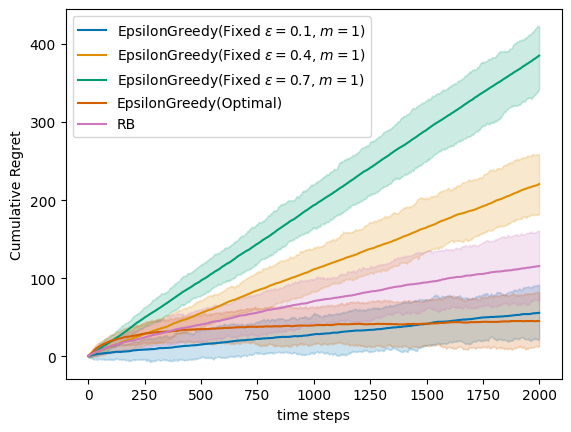

In [13]:
# Framework for the experiments
n_arms = 2
means = [0.2, 0.75]
env = BernoulliBanditEnv(means = means)
n_rounds = 1000
delta = 0.1
eps0 = EpsilonGreedy(K=len(means), eps = 0.1, FixedEpsilon = True, m = 1) 
eps04 = EpsilonGreedy(K=len(means), eps = 0.4, FixedEpsilon = True, m = 1) 
eps07 = EpsilonGreedy(K=len(means), eps = 0.7, FixedEpsilon = True, m = 1) 
epsOpti = EpsilonGreedy(K=len(means), Delta = 0.55, m = 1)
epsAlgo = [eps0, eps04, eps07, epsOpti]
rb_agent = RegretBalancingAgent(learners = epsAlgo, 
                                K = n_arms, 
                                delta = delta, 
                                u_bounds = [lambda x : np.sqrt(x * n_arms) for _ in range(len(epsAlgo))],
                                env = env)
eps_rb = [eps0, eps04, eps07, epsOpti, rb_agent]
Nmc = 100  
T = 2000  

# Run experiments
all_data = experiment(env, eps_rb, Nmc, T, bern=True)

# Plot results
plot_regret(regrets = all_data, logscale = False, lb = None, q = 10)  #, save_pdf = 'Regret_Balancing_EpsGreedy.pdf')

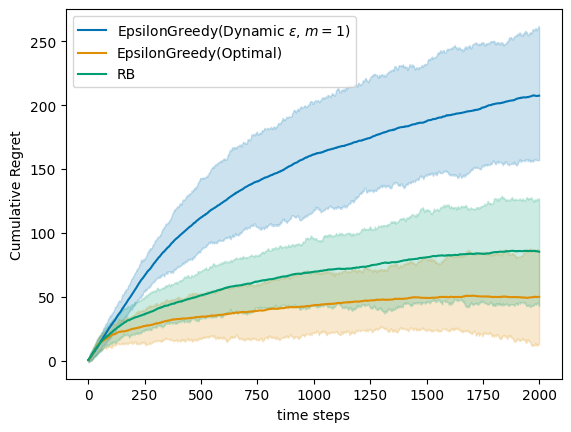

In [15]:
n_arms = 2
means = [0.2, 0.75]
env = BernoulliBanditEnv(means = means)
n_rounds = 1000
delta = 0.1
eps0_vary = EpsilonGreedy(K=len(means), FixedEpsilon = False, m = 1) 
epsOpti = EpsilonGreedy(K=len(means), Delta = 0.55, m = 1)
epsAlgo = [eps0_vary, epsOpti]
rb_agent = RegretBalancingAgent(learners = epsAlgo, 
                                K = n_arms, 
                                delta = delta, 
                                u_bounds = [lambda x : np.sqrt(x * n_arms) for _ in range(len(epsAlgo))],
                                env = env)
eps_rb = [eps0_vary, epsOpti, rb_agent]
Nmc = 100  
T = 2000  
all_data = experiment(env, eps_rb, Nmc, T, bern=True)
plot_regret(regrets = all_data, logscale = False, lb = None, q = 10)  #, save_pdf = 'Regret_Balancing_EpsGreedy_not_fix.pdf')

## Now, we introduce the Upper Confidence Bound algorithm and Linear Upper Confidence Bound algorithm

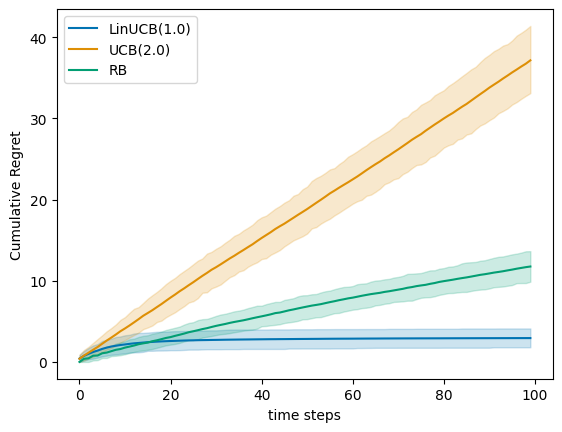

In [14]:
d = 10  # dimension
K = 5  # number of arms

# parametor vector \theta, normalized :
thetaTrue = ActionsGenerator(1,d)[0]
thetaTrue /= np.linalg.norm(thetaTrue)

T = 100  # Finite Horizon
N = 250  # Monte Carlo simulations

delta = 0.1 
sigma = 0.1

#choice of percentile display
q = 10

# Framework for the experiments
actionSet = random.shuffle(ActionsGenerator(K,d))
env = LinearBandit(thetaTrue, K, var=sigma**2, fixed_actions=actionSet)

# Initialization of the agents
linucb = LinUCB(d=d, lambda_reg=1., delta=delta, sigma=sigma)
ucb = UCB(K=K, alpha=2.)
UCBs = [linucb, ucb]
rb_agent = RegretBalancingAgent(learners = UCBs, 
                                K = K, 
                                delta = delta, 
                                u_bounds = [lambda x : np.sqrt(x * K) for _ in range(len(UCBs))],
                                env = env)

# Run experiments
all_data = experiment(env, [linucb, ucb, rb_agent], Nmc=N, T=T, bern=False)

# Plot results
plot_regret(regrets = all_data, logscale = False, lb = None, q = 10)  # , save_pdf='RBucb.pdf')

## Let's work on real data ! 

First, we load the data:

In [17]:
df = create_dataframe()

df.head()

reading movielens 20m data
preparing ratings log


,userId,movieId,rating,timestamp,movieId_movie,title,(no genres listed),Action,Adventure,Animation,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,t,liked
t,,,,,,,,,,,,,,,,,,,,,
0,106458,1393,3.5,1107757581,1432.0,Metro (1997),False,True,False,False,...,False,False,False,False,False,True,False,False,0,0
1,31655,1584,3.0,1174520906,1646.0,RocketMan (a.k.a. Rocket Man) (1997),False,False,False,False,...,False,False,False,True,True,False,False,False,1,0
2,91964,1721,4.5,1504912903,1801.0,"Man in the Iron Mask, The (1998)",False,True,True,False,...,False,False,False,False,False,False,False,False,2,1
3,42097,44191,4.0,1337587891,167704.0,Life of the Party (1920),False,False,False,False,...,False,False,False,False,False,False,False,False,3,0
4,75460,2355,4.5,1059787918,2446.0,In Dreams (1999),False,False,False,False,...,False,False,False,False,False,True,False,False,4,1


Define the score function: 

In [20]:
def score(history, df, t, batch_size, recs):
    # https://arxiv.org/pdf/1003.5956.pdf
    # replay score. reward if rec matches logged data, ignore otherwise
    #actions = df.copy()[t:t+batch_size]
    actions = df[t:t+batch_size]
    actions = actions.loc[actions['movieId'].isin(recs)]
    actions['scoring_round'] = t
    # add row to history if recs match logging policy
    history = pd.concat([history,actions])
    action_liked = actions[['movieId', 'liked']]
    return history, action_liked

###  Run experiments

In [21]:
n=5 
epsilon=.01 
epsilon2=.2
batch_size=10000 
min_review_count=1500
verbose = 'FALSE'
balanced_classes = False

#### EpsilonGreedy Policy

##### Fixed $ \epsilon $

Definition of Base Learner 

In [19]:
def epsilon_greedy_policy(df, arms, epsilon=0.15, c = 0, t = 0, slate_size=5, batch_size=50, fixed = True):
    """
    Epsilon-Greedy Policy for Recommender Systems or Bandit Problems.

    This function implements an epsilon-greedy policy to decide which items 
    to recommend to users based on historical data of user interactions.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset containing user interactions with items. It should include:
        - 'movieId': Identifier for the items (e.g., movies).
        - 'liked': Indicator of whether the user liked the item (1 for like, 0 for dislike).
    arms : list
        The set of all possible items that can be recommended (e.g., a list of movie IDs).
    epsilon : float, optional, default=0.15
        The probability of exploring (choosing random items) rather than exploiting
        (choosing the best-performing items so far).
    slate_size : int, optional, default=5
        The number of recommendations to generate in each step.
    batch_size : int, optional, default=50
        The number of users to serve recommendations before potentially updating the policy.
        (Not directly used in this function but relevant in larger batch-processing contexts).

    Returns
    -------
    recs : numpy.ndarray
        An array of item IDs representing the recommendations for the current step.

    Policy Logic
    ------------
    - With a probability of `epsilon`, the policy chooses to explore:
      - A random set of `slate_size` items is selected from `arms` without replacement.
    - Otherwise (with a probability of `1 - epsilon`), the policy chooses to exploit:
      - Items are ranked by their average like rate (`liked` column in `df`).
      - The top `slate_size` items with the highest mean like rates are recommended.
    - If `df` is empty, the policy defaults to exploration.
    """

    if fixed == False:
        if t==0 :
            epsilon =1
        else:
            epsilon = c/t
     
    # Draw a 0 or 1 from a binomial distribution, with epsilon likelihood of drawing a 1
    explore = np.random.binomial(1, min(1, epsilon))
    
    # If exploring, shuffle items to choose a random set of recommendations
    if explore == 1 or df.shape[0] == 0:
        recs = np.random.choice(arms, size=(slate_size), replace=False)

    # If exploiting, sort items by "like rate" and recommend the best-performing items
    else:
        scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count']})
        scores.columns = ['mean', 'count']
        scores['movieId'] = scores.index
        scores = scores.sort_values('mean', ascending=False)
        recs = scores.loc[scores.index[0:slate_size], 'movieId'].values

    return recs

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_11036/308017615.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history,actions])


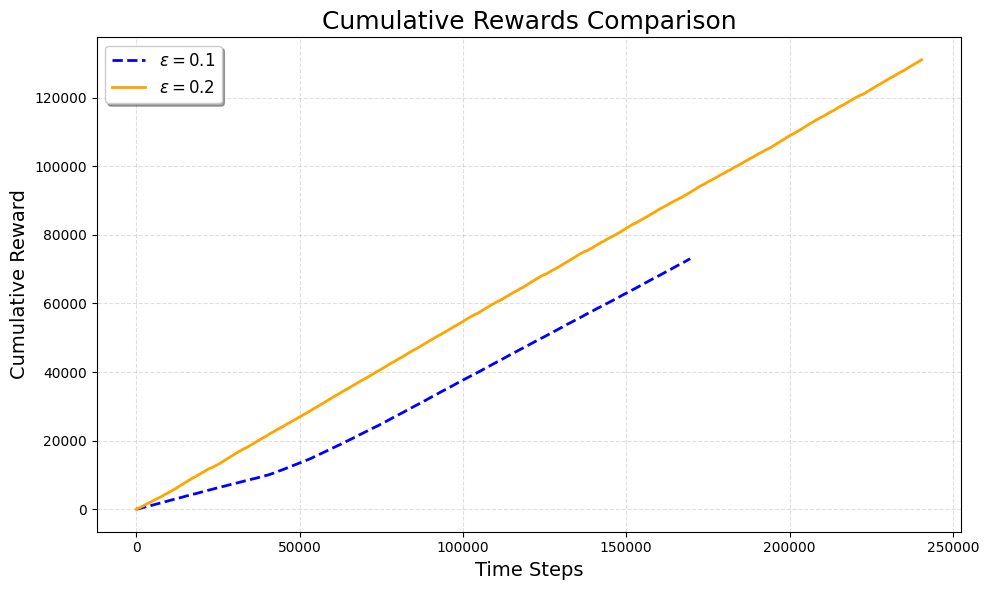

In [22]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({'movieId': 'int32', 'liked': 'float'})


# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)
	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history.loc[history.t<=t,], arms=df.movieId.unique(), epsilon=epsilon, slate_size=n, batch_size=batch_size)
	history, action_score = score(history, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards.extend(action_score)
		

# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history2 = pd.DataFrame(data=None, columns=df.columns)
history2 = history.astype({'movieId': 'int32', 'liked': 'float'})

# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards2 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)
	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history2.loc[history2.t<=t,], arms=df.movieId.unique(), epsilon=epsilon2, slate_size=n, batch_size=batch_size)
	history2, action_score = score(history2, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards2.extend(action_score)

cumsum_rewards = np.cumsum(rewards)
cumsum_rewards2 = np.cumsum(rewards2)

plt.figure(figsize=(10, 6))
plt.plot(cumsum_rewards, label=r'$\epsilon = 0.1$', linewidth=2, linestyle='--', color='blue')
plt.plot(cumsum_rewards2, label=r'$\epsilon = 0.2$', linewidth=2, linestyle='-', color='orange')
plt.title("Cumulative Rewards Comparison", fontsize=18)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Cumulative Reward", fontsize=14)
plt.grid(alpha=0.4, linestyle='--')
plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)
plt.tight_layout()
plt.show()

##### Varying $\varepsilon_t$

In [23]:
c = 1e5

# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history3 = pd.DataFrame(data=None, columns=df.columns)
history3 = history.astype({'movieId': 'int32', 'liked': 'float'})

# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards3 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)
	# choose which arm to pull
	if t == 0:
		epsilon3 = c
	else:
		epsilon3 = c/t
	if t % 10:
		print(epsilon3)
	recs = epsilon_greedy_policy(df=history3.loc[history3.t<=t,], arms=df.movieId.unique(), epsilon=epsilon3, slate_size=n, batch_size=batch_size)
	history3, action_score = score(history3, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards3.extend(action_score)

<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_11036/2345089125.py:9: SyntaxWarning: invalid escape sequence '\e'
  plt.title("Comparison of Cumulative Rewards for Different $\epsilon$", fontsize=18)


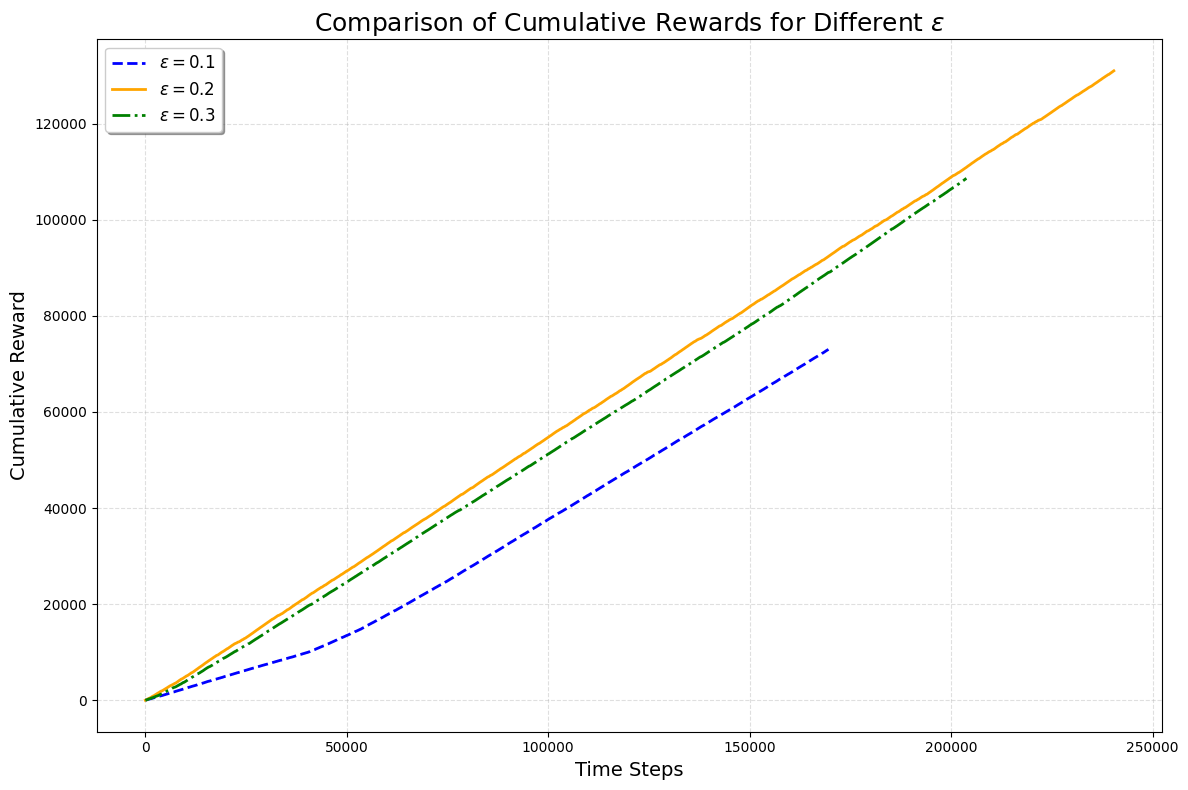

In [24]:
cumsum_rewards = np.cumsum(rewards)
cumsum_rewards2 = np.cumsum(rewards2)
cumsum_rewards3 = np.cumsum(rewards3)

plt.figure(figsize=(12, 8))
plt.plot(cumsum_rewards, label=r'$\epsilon = 0.1$', linewidth=2, linestyle='--', color='blue')
plt.plot(cumsum_rewards2, label=r'$\epsilon = 0.2$', linewidth=2, linestyle='-', color='orange')
plt.plot(cumsum_rewards3, label=r'$\epsilon = 0.3$', linewidth=2, linestyle='-.', color='green')
plt.title("Comparison of Cumulative Rewards for Different $\epsilon$", fontsize=18)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Cumulative Reward", fontsize=14)
plt.grid(alpha=0.4, linestyle='--')
plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)
plt.tight_layout()
plt.show()

We've different end time since in the training loop we check if we can receive a feed back, not equal among all run.

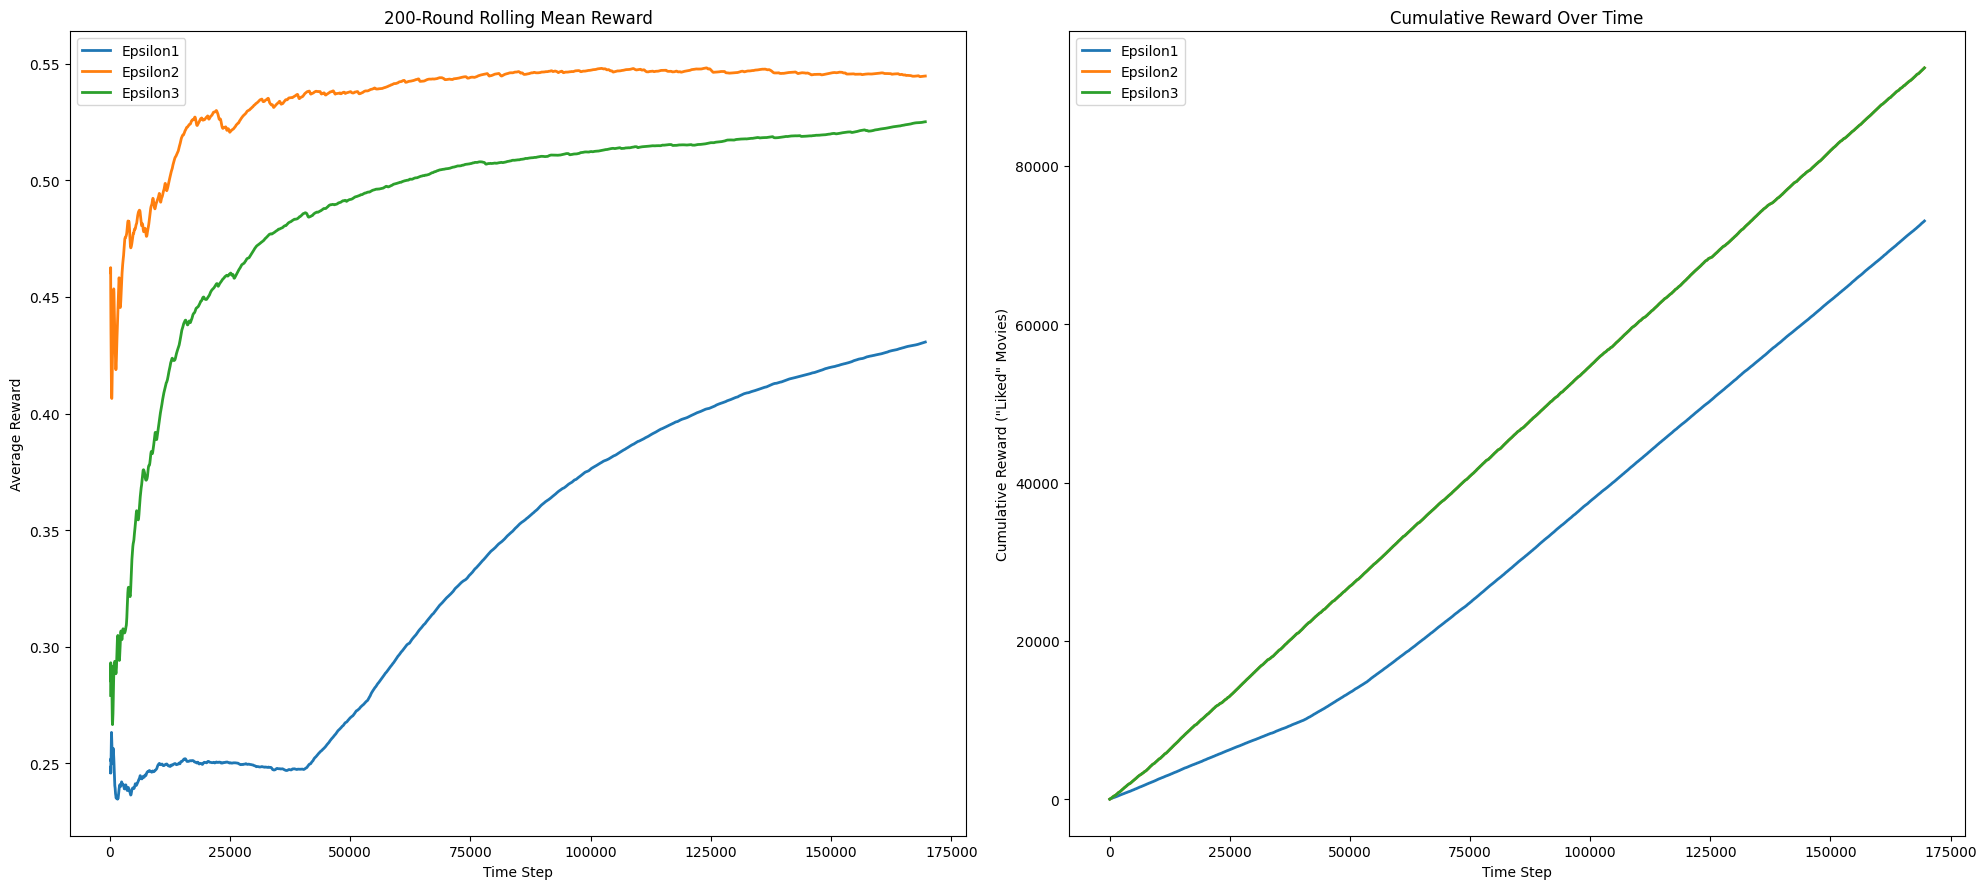

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,9))

L = min(len(rewards), len(rewards2), len(rewards3))
lw=2

cumulative_epsilon1 = np.cumsum(rewards[:L]) 
cumulative_epsilon2 = np.cumsum(rewards2[:L])
cumulative_epsilon3 = np.cumsum(rewards3[:L])

axes[1].plot(pd.Series(cumulative_epsilon1), lw=lw, label='Epsilon1')
axes[1].plot(pd.Series(cumulative_epsilon2), lw=lw, label='Epsilon2')
axes[1].plot(pd.Series(cumulative_epsilon2), lw=lw, label='Epsilon3')


axes[1].set_title('Cumulative Reward Over Time')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Cumulative Reward ("Liked" Movies)')
axes[1].legend()


cumulative_epsilon1 = np.cumsum(rewards[:L]) / np.linspace(1, len(rewards[:L]), len(rewards[:L]))
cumulative_epsilon2 = np.cumsum(rewards2[:L]) / np.linspace(1, len(rewards2[:L]), len(rewards2[:L]))
cumulative_epsilon3 = np.cumsum(rewards3[:L]) / np.linspace(1, len(rewards3[:L]), len(rewards3[:L]))

axes[0].plot(pd.Series(cumulative_epsilon1).rolling(200).mean(), lw=lw, label='Epsilon1')
axes[0].plot(pd.Series(cumulative_epsilon2).rolling(200).mean(), lw=lw, label='Epsilon2')
axes[0].plot(pd.Series(cumulative_epsilon3).rolling(200).mean(), lw=lw, label='Epsilon3')
axes[0].set_title('200-Round Rolling Mean Reward')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Average Reward')
axes[0].legend()

fig.tight_layout()

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_11036/308017615.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history,actions])


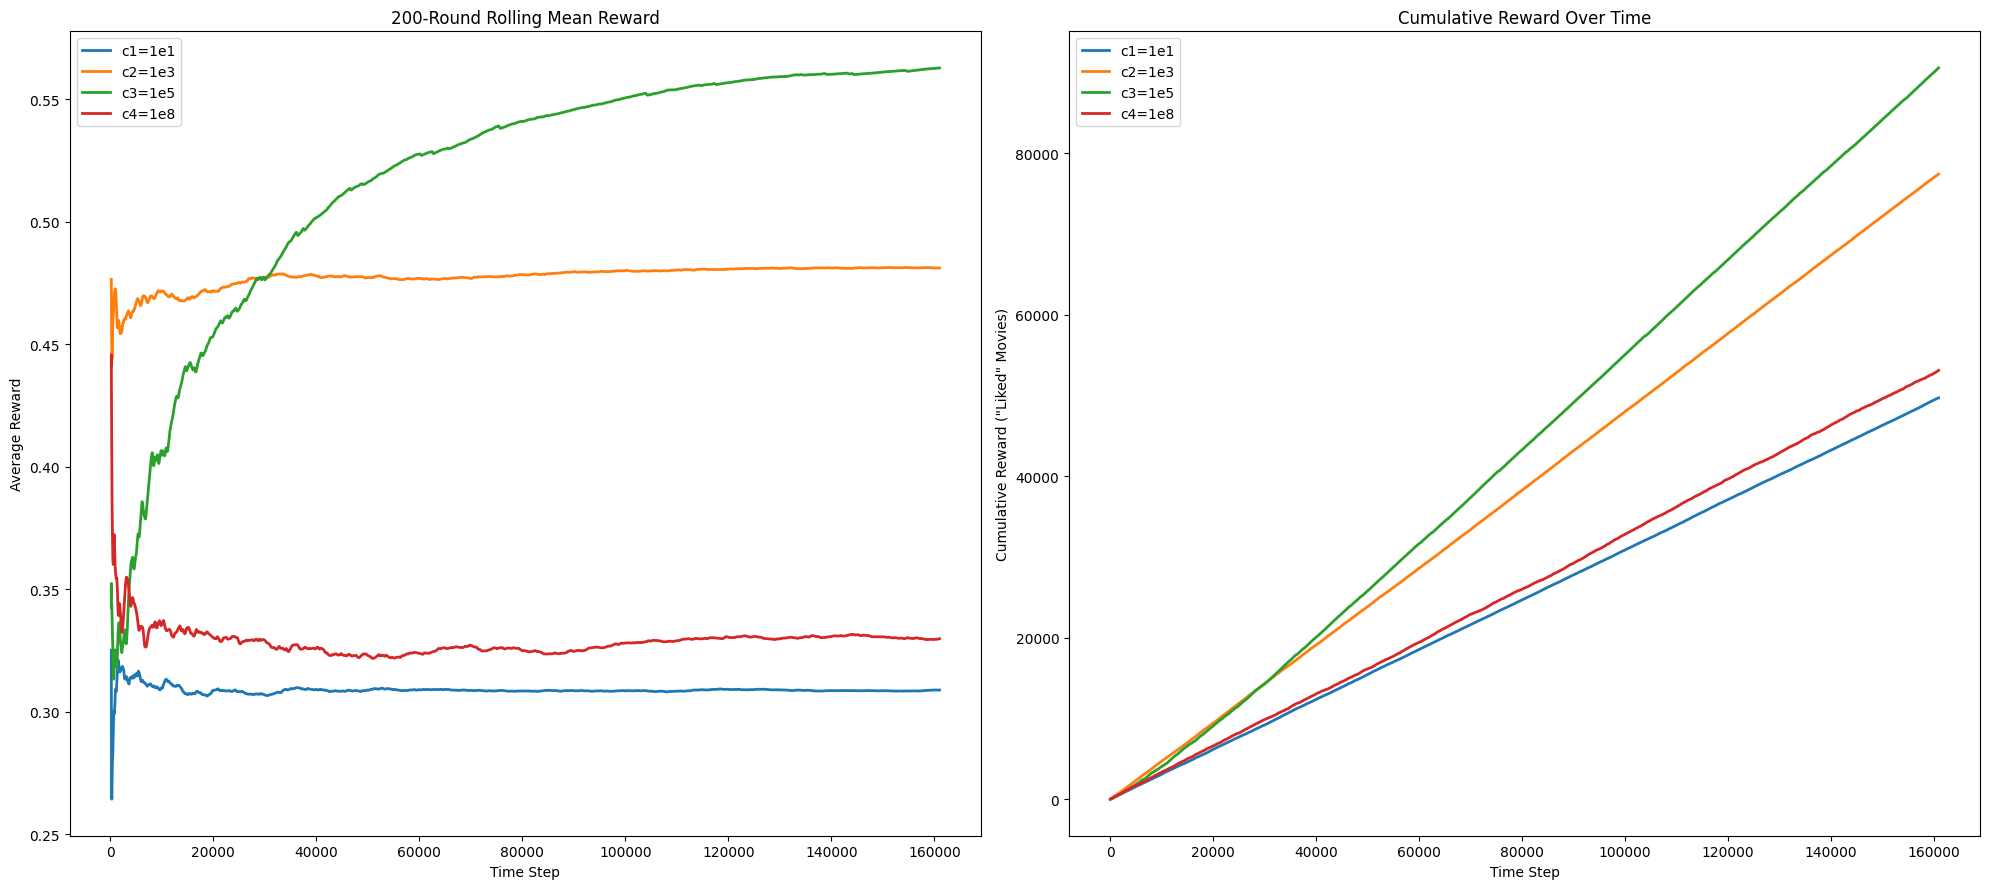

In [26]:
# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({'movieId': 'int32', 'liked': 'float'})

#def c in c/t for eps greedy 4
c=1e1

# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
rewards = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)

	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history.loc[history.t<=t,], arms=df.movieId.unique(), c=c, t=t, slate_size=n, batch_size=batch_size, fixed=False)
	history, action_score = score(history, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards.extend(action_score)
		

# 2
history2 = pd.DataFrame(data=None, columns=df.columns)
history2 = history.astype({'movieId': 'int32', 'liked': 'float'})

c2=1e3
rewards2 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)

	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history2.loc[history2.t<=t,], arms=df.movieId.unique(), c=c2, t=t, slate_size=n, batch_size=batch_size, fixed=False)
	history2, action_score = score(history2, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards2.extend(action_score)
		
# 3
history3 = pd.DataFrame(data=None, columns=df.columns)
history3 = history.astype({'movieId': 'int32', 'liked': 'float'})


c3=1e5

rewards3 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)

	recs = epsilon_greedy_policy(df=history3.loc[history3.t<=t,], arms=df.movieId.unique(), c=c3, t=t, slate_size=n, batch_size=batch_size, fixed=False)
	history3, action_score = score(history3, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards3.extend(action_score)

#4		
history4 = pd.DataFrame(data=None, columns=df.columns)
history4 = history.astype({'movieId': 'int32', 'liked': 'float'})


c4=1e8

rewards4 = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//batch_size): #df.t:
	t = t * batch_size
	if t % 100000 == 0:
		if verbose == 'TRUE':
			print(t)

	# choose which arm to pull
	recs = epsilon_greedy_policy(df=history4.loc[history4.t<=t,], arms=df.movieId.unique(), c=c4, t=t, slate_size=n, batch_size=batch_size, fixed=False)
	history4, action_score = score(history4, df, t, batch_size, recs)
	if action_score is not None:
		action_score = action_score.liked.tolist()
		rewards4.extend(action_score)
		
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,9))

L = min(len(rewards), len(rewards2), len(rewards3), len(rewards4))
lw=2

cumulative_epsilon1 = np.cumsum(rewards[:L]) 
cumulative_epsilon2 = np.cumsum(rewards2[:L])
cumulative_epsilon3 = np.cumsum(rewards3[:L])
cumulative_epsilon4 = np.cumsum(rewards4[:L])

axes[1].plot(pd.Series(cumulative_epsilon1), lw=lw, label='c1=1e1')
axes[1].plot(pd.Series(cumulative_epsilon2), lw=lw, label='c2=1e3')
axes[1].plot(pd.Series(cumulative_epsilon3), lw=lw, label='c3=1e5')
axes[1].plot(pd.Series(cumulative_epsilon4), lw=lw, label='c4=1e8')



axes[1].set_title('Cumulative Reward Over Time')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Cumulative Reward ("Liked" Movies)')
axes[1].legend()


cumulative_epsilon1 = np.cumsum(rewards[:L]) / np.linspace(1, len(rewards[:L]), len(rewards[:L]))
cumulative_epsilon2 = np.cumsum(rewards2[:L]) / np.linspace(1, len(rewards2[:L]), len(rewards2[:L]))
cumulative_epsilon3 = np.cumsum(rewards3[:L]) / np.linspace(1, len(rewards3[:L]), len(rewards3[:L]))
cumulative_epsilon4 = np.cumsum(rewards4[:L]) / np.linspace(1, len(rewards4[:L]), len(rewards4[:L]))


axes[0].plot(pd.Series(cumulative_epsilon1).rolling(200).mean(), lw=lw, label='c1=1e1')
axes[0].plot(pd.Series(cumulative_epsilon2).rolling(200).mean(), lw=lw, label='c2=1e3')
axes[0].plot(pd.Series(cumulative_epsilon3).rolling(200).mean(), lw=lw, label='c3=1e5')
axes[0].plot(pd.Series(cumulative_epsilon4).rolling(200).mean(), lw=lw, label='c4=1e8')
axes[0].set_title('200-Round Rolling Mean Reward')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Average Reward')
axes[0].legend()

fig.tight_layout()

Now we use Regret Balancing with this base learner

In [27]:
def RunRegretBalancingEpsilonGreedy(df, history, learners, slate_size, batch_size, verbose=False):
    #history_init = history.copy()
    history_init_RB = history.copy()
    arms = df.movieId.unique()
    K = len(arms)
    R = np.zeros(len(learners))
    N = np.ones(len(learners))
    G = np.zeros(len(learners))
    t = 0
    rewards = []
    max_time = df.shape[0]
    

    # Iterate over batches
    for step in range(max_time // batch_size):
        t = step * batch_size
        u_bound = lambda t: np.sqrt(K * t)

        # Print progress if verbose is enabled
        if verbose and t % 100000 == 0:
            print(f"Processing step {t}...")

        set_to_maximize_index = [(R[i] / N[i]) + (u_bound(t) / N[i]) for i in range(len(learners))]
        j_t = np.argmax(set_to_maximize_index)
        b_t = set_to_maximize_index[j_t]
        # Empirical regret of base i at round t:

        G = N * b_t - R
        i_t = np.argmin(G)

        recs = epsilon_greedy_policy(df=history_init_RB.loc[history_init_RB.t<=t,], arms=df.movieId.unique(), c=learners[i_t], t=t, slate_size=slate_size, batch_size=batch_size, fixed=False)
        N[i_t] += 1
        # Score the recommendations and update history
        history_init_RB, action_score = score(history_init_RB, df, t, batch_size, recs)

        # Accumulate rewards from action scores
        if action_score is not None:
            Rs = action_score.liked.tolist()
            rewards.extend(Rs)
            R[i_t] += np.sum(Rs)
        
    return rewards, history_init_RB

In [28]:
learners = [c, c2, c3, c4]

# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history_rb = pd.DataFrame(data=None, columns=df.columns)
history_rb = history.astype({'movieId': 'int32', 'liked': 'float'})

rewardsRB, historyRB = RunRegretBalancingEpsilonGreedy(df, history_rb, learners=learners, slate_size=n, batch_size=batch_size)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

L = min(len(rewards), len(rewards2), len(rewards3), len(rewards4), len(rewardsRB))
lw=2

cumulative_epsilon1 = np.cumsum(rewards[:L]) 
cumulative_epsilon2 = np.cumsum(rewards2[:L])
cumulative_epsilon3 = np.cumsum(rewards3[:L])
cumulative_epsilon4 = np.cumsum(rewards4[:L])
cumulative_epsilonRB = np.cumsum(rewardsRB[:L])

axes[1].plot(pd.Series(cumulative_epsilon1), lw=lw, label='c1=1e1')
axes[1].plot(pd.Series(cumulative_epsilon2), lw=lw, label='c2=1e3')
axes[1].plot(pd.Series(cumulative_epsilon3), lw=lw, label='c3=1e5')
axes[1].plot(pd.Series(cumulative_epsilon4), lw=lw, label='c4=1e8')
axes[1].plot(pd.Series(cumulative_epsilonRB), lw=lw, label='RB')


axes[1].set_title('Cumulative Reward Over Time')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Cumulative Reward ("Liked" Movies)')
axes[1].legend()


cumulative_epsilon1 = np.cumsum(rewards[:L]) / np.linspace(1, len(rewards[:L]), len(rewards[:L]))
cumulative_epsilon2 = np.cumsum(rewards2[:L]) / np.linspace(1, len(rewards2[:L]), len(rewards2[:L]))
cumulative_epsilon3 = np.cumsum(rewards3[:L]) / np.linspace(1, len(rewards3[:L]), len(rewards3[:L]))
cumulative_epsilon4 = np.cumsum(rewards4[:L]) / np.linspace(1, len(rewards4[:L]), len(rewards4[:L]))
cumulative_epsilonRB = np.cumsum(rewardsRB[:L]) / np.linspace(1, len(rewardsRB[:L]), len(rewardsRB[:L]))


axes[0].plot(pd.Series(cumulative_epsilon1).rolling(200).mean(), lw=lw, label='c1=1e1')
axes[0].plot(pd.Series(cumulative_epsilon2).rolling(200).mean(), lw=lw, label='c2=1e3')
axes[0].plot(pd.Series(cumulative_epsilon3).rolling(200).mean(), lw=lw, label='c3=1e5')
axes[0].plot(pd.Series(cumulative_epsilon4).rolling(200).mean(), lw=lw, label='c4=1e8')
axes[0].plot(pd.Series(cumulative_epsilonRB).rolling(200).mean(), lw=lw, label='RB')
axes[0].set_title('200-Round Rolling Mean Reward')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Average Reward')
axes[0].legend()

fig.tight_layout()